In [3]:
import pandas as pd
import numpy as np
import re
from gensim import corpora, models, similarities, matutils
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import time

C:\Users\rohan\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
# Import Dataset and remove empty rows
df = pd.read_csv('Foodsaver_1.csv')
# df = df.dropna(subset=['reviews.text'])
df

,reviews.rating,reviews.text
0,1,I am thinking it is ready to use. I did not kn...
1,1,I bought this a month ago. I tried vacuum seal...
2,1,the first one I received would not work at all...
3,1,I cannot make heads or tails out of how to use...
4,1,I have tried to use all and found that none of...
5,1,Seal did not hold. I buy a lot of foodsaver pr...
6,1,I tried numerous times and it doesn't stay sea...
7,1,I did not like the item because the item did n...
8,1,"We bought this container as part of a package,..."
9,1,"I really liked the earlier versions of these, ..."


In [5]:
# data overview
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : ', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  44
Columns  :  2

Features :  ['reviews.rating', 'reviews.text']

Missing values :   0

Unique values :  
 reviews.rating     1
reviews.text      44
dtype: int64


In [6]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 2 columns):
reviews.rating    44 non-null int64
reviews.text      44 non-null object
dtypes: int64(1), object(1)
memory usage: 784.0+ bytes


reviews.rating    0
reviews.text      0
dtype: int64

In [8]:
df['no_punctuation'] = df['reviews.text'].str.replace('[^\w\s]','')
df['lower_case'] = df['no_punctuation'].astype(str).str.lower()
df['tokenized_text'] = df['lower_case'].apply(word_tokenize)
df['key_words'] =df['tokenized_text'].apply(lambda x: [item for item in x if item not in stopwords.words('english')])
df

,reviews.rating,reviews.text,no_punctuation,lower_case,tokenized_text,key_words
0,1,I am thinking it is ready to use. I did not kn...,I am thinking it is ready to use I did not kno...,i am thinking it is ready to use i did not kno...,"[i, am, thinking, it, is, ready, to, use, i, d...","[thinking, ready, use, know, needed, buy, part..."
1,1,I bought this a month ago. I tried vacuum seal...,I bought this a month ago I tried vacuum seali...,i bought this a month ago i tried vacuum seali...,"[i, bought, this, a, month, ago, i, tried, vac...","[bought, month, ago, tried, vacuum, sealing, s..."
2,1,the first one I received would not work at all...,the first one I received would not work at all...,the first one i received would not work at all...,"[the, first, one, i, received, would, not, wor...","[first, one, received, would, work, replaced, ..."
3,1,I cannot make heads or tails out of how to use...,I cannot make heads or tails out of how to use...,i cannot make heads or tails out of how to use...,"[i, can, not, make, heads, or, tails, out, of,...","[make, heads, tails, use, product, sell, parts..."
4,1,I have tried to use all and found that none of...,I have tried to use all and found that none of...,i have tried to use all and found that none of...,"[i, have, tried, to, use, all, and, found, tha...","[tried, use, found, none, containers, hold, va..."
5,1,Seal did not hold. I buy a lot of foodsaver pr...,Seal did not hold I buy a lot of foodsaver pro...,seal did not hold i buy a lot of foodsaver pro...,"[seal, did, not, hold, i, buy, a, lot, of, foo...","[seal, hold, buy, lot, foodsaver, products, fi..."
6,1,I tried numerous times and it doesn't stay sea...,I tried numerous times and it doesnt stay seal...,i tried numerous times and it doesnt stay seal...,"[i, tried, numerous, times, and, it, doesnt, s...","[tried, numerous, times, doesnt, stay, sealed,..."
7,1,I did not like the item because the item did n...,I did not like the item because the item did n...,i did not like the item because the item did n...,"[i, did, not, like, the, item, because, the, i...","[like, item, item, say, sealed]"
8,1,"We bought this container as part of a package,...",We bought this container as part of a package ...,we bought this container as part of a package ...,"[we, bought, this, container, as, part, of, a,...","[bought, container, part, package, three, cont..."
9,1,"I really liked the earlier versions of these, ...",I really liked the earlier versions of these d...,i really liked the earlier versions of these d...,"[i, really, liked, the, earlier, versions, of,...","[really, liked, earlier, versions, decided, ge..."


In [9]:
df['joined_Sent'] = [' '.join(map(str, indStem)) for indStem in df['key_words']]

In [14]:
word_vectorizer = CountVectorizer(ngram_range =(1,3), analyzer = 'word')
sparse_matrix = word_vectorizer.fit_transform(df['joined_Sent'])

In [15]:
df_doc_term = pd.DataFrame(sparse_matrix.toarray(), columns = word_vectorizer.get_feature_names())
df_doc_term.shape

(44, 2187)

In [16]:
df_doc_term

,10,10 cup,10 cup container,10 cup containers,10 min,10 min trying,10c,10c rectangular,10c rectangular container,12,...,years happy two,years new,years new containers,yesterday,yesterday upon,yesterday upon first,zip,zip lock,zip lock bag,zip lock bags
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
time1 = time.time()
corpus = matutils.Sparse2Corpus(sparse_matrix)
id2word = dict((v,k) for k, v in word_vectorizer.vocabulary_.items())
lda = models.LdaModel(corpus = corpus, num_topics = 3, id2word=id2word, passes=5)
lda.print_topics()
lda_corpus = lda[corpus]
lda_docs = [doc for doc in lda_corpus]
lda_docs[0:10]
t=time.time() - time1
print(t)

4.472379207611084


In [20]:
lda.print_topics()

[(0,
  '0.113*"accessories hoping answer" + 0.076*"10 cup container" + 0.070*"accessories" + 0.047*"abut 10 min" + 0.032*"24 hrs bad" + 0.031*"30 minutes review" + 0.031*"24" + 0.023*"absolutely useless regular" + 0.018*"10 min" + 0.017*"10 min trying"'),
 (1,
  '0.098*"abysmal" + 0.072*"2nd time" + 0.071*"12" + 0.061*"ago" + 0.059*"30 seconds" + 0.047*"24 hrs" + 0.044*"able get seal" + 0.037*"10 cup" + 0.024*"24 hours sometimes" + 0.023*"12 hours"'),
 (2,
  '0.132*"abut 10" + 0.098*"absolutely" + 0.067*"2nd time see" + 0.056*"abut" + 0.037*"10c rectangular container" + 0.034*"advertised seal two" + 0.031*"24 hours" + 0.026*"30 seconds sealing" + 0.025*"advertised seal" + 0.024*"absolutely useless"')]

In [22]:
time1 = time.time()
lsa = TruncatedSVD(3)
df_doc_topic=lsa.fit_transform(df_doc_term)
lsa.explained_variance_ratio_
topic_word = pd.DataFrame(lsa.components_.round(10), index = ["component_1", "component_2", "component_3"],columns = word_vectorizer.get_feature_names())

In [23]:
topic_word

,10,10 cup,10 cup container,10 cup containers,10 min,10 min trying,10c,10c rectangular,10c rectangular container,12,...,years happy two,years new,years new containers,yesterday,yesterday upon,yesterday upon first,zip,zip lock,zip lock bag,zip lock bags
component_1,0.017619,0.013066,0.009033,0.004033,0.004553,0.004553,0.016356,0.016356,0.016356,0.000419,...,0.004806,0.034614,0.034614,0.001966,0.001966,0.001966,0.039994,0.039994,0.034614,0.005380
component_2,-0.003736,-0.002042,-0.002119,0.000077,-0.001694,-0.001694,0.000969,0.000969,0.000969,0.000728,...,0.003718,-0.043399,-0.043399,0.003155,0.003155,0.003155,-0.041748,-0.041748,-0.043399,0.001651
component_3,0.012666,0.008076,0.006565,0.001511,0.004590,0.004590,0.014246,0.014246,0.014246,-0.000429,...,-0.003036,-0.022692,-0.022692,-0.001175,-0.001175,-0.001175,-0.022807,-0.022807,-0.022692,-0.000115


In [24]:
def display_topics(model, feature_names, no_top_words, topic_names = None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print(ix)
        else:
            print(topic_names[ix])
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
display_topics(lsa, word_vectorizer.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))

0
seal, containers, container, vacuum, hold, use, well, bought, work, new, keep, days, hold seal, dont, would, lids, set, things, keep seal, smoked
1
vacuum, storage, dont, bought, lids, set, using, container, lids dont, storage containers, time, ago, bought set, stay, months, one, months ago, couple, expensive, containers months
2
seal, ones, foodsaver, long, long time, square, time, really, one, container, reliable, hold, love, hold seal, reason, good, know, bad, seems, dont know

Time Taken: 231.25 seconds


In [25]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(3)
doc_topic = nmf_model.fit_transform(df_doc_term)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = word_vectorizer.get_feature_names())
topic_word
display_topics(nmf_model, word_vectorizer.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))

0
seal, containers, well, keep, work, new, hold, smoked, things, keep seal, days, use, container, would, two, hold seal, three, old, anymore, lock
1
vacuum, containers, storage, lids, dont, bought, using, lids dont, storage containers, container, ago, months, months ago, set, couple, expensive, store, containers months, containers months ago, floor
2
seal, foodsaver, ones, time, long, long time, use, containers, set, one, container, bought, dont, square, really, reliable, good, know, dont know, seems

Time Taken: 0.26 seconds


In [26]:
# Document-Term Matrix - TF-IDF
cv_tfidf = TfidfVectorizer(ngram_range=(1,3), analyzer='word')
sparse_matrix = cv_tfidf.fit_transform(df["joined_Sent"])
df_doc_term_TFIDF = pd.DataFrame(sparse_matrix.toarray(), columns=cv_tfidf.get_feature_names())
df_doc_term_TFIDF.shape
# df_doc_term_TFIDF.to_csv("df_doc_term_TFIDF.csv", index=True)

(44, 2187)

In [27]:
df_doc_term_TFIDF

,10,10 cup,10 cup container,10 cup containers,10 min,10 min trying,10c,10c rectangular,10c rectangular container,12,...,years happy two,years new,years new containers,yesterday,yesterday upon,yesterday upon first,zip,zip lock,zip lock bag,zip lock bags
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.233246,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [28]:
lda.print_topics()
time1 = time.time()
# Convert sparse matrix of counts to a gensim corpus 
corpus = matutils.Sparse2Corpus(sparse_matrix)
# Map matrix rows to words (tokens)
id2word = dict((v, k) for k, v in cv_tfidf.vocabulary_.items())
# len(id2word)
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)
# 10 most important words for each of the 3 topics
lda.print_topics()
# Transform the docs from word space to topic space
lda_corpus = lda[corpus]
# Store the doc topic vectors in a list for review
lda_docs = [doc for doc in lda_corpus]
# Find the document vectors in the topic space for the first 10 documents
lda_docs[0:10] 
time2 = time.time()
time_taken = time2 - time1
print(time_taken)

3.9120900630950928


In [29]:
lda.print_topics()

[(0,
  '0.016*"abut 10 min" + 0.014*"abut" + 0.014*"absolutely" + 0.011*"10 cup container" + 0.011*"10c rectangular container" + 0.010*"24 hours" + 0.009*"abut 10" + 0.009*"10 cup" + 0.007*"10 min" + 0.006*"30 minutes review"'),
 (1,
  '0.012*"30 seconds" + 0.012*"2nd time see" + 0.011*"abut 10" + 0.009*"30 seconds sealing" + 0.007*"absolutely useless" + 0.007*"24 hrs bad" + 0.007*"able get" + 0.004*"10 min trying" + 0.004*"2nd time" + 0.004*"10 cup container"'),
 (2,
  '0.014*"abysmal" + 0.012*"accessories hoping answer" + 0.012*"accessories" + 0.010*"12" + 0.010*"ago" + 0.008*"advertised seal two" + 0.006*"able" + 0.006*"2nd time see" + 0.006*"24 hrs" + 0.006*"24"')]

In [30]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(3)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 10 key words for each of the 6 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
seal, containers, hold, vacuum, container, bought, work, one, day, hold vacuum, dont, hold seal, use, get, expensive, lids, tried, set, ago, new

Topic  1
seal, get, able, get seal, able get, able get seal, suction, last one day, last one, get seal last, seal last, seal last one, last, ive, parts, one day, make, lost, frustrating, seal hold

Topic  2
sealed, stay sealed, stay, times doesnt stay, sealed 12 hours, doesnt stay sealed, tried numerous, tried numerous times, times doesnt, sealed 12, stay sealed 12, numerous, numerous times, numerous times doesnt, doesnt stay, 12 hours, 12, container stay sealed, container stay, bought four pieces

Time Taken: 0.05 seconds


In [31]:
# Topic Modeling with Matrix Factorization and LSA (Latent Semantic Analysis) aka Singular Value Decomposition (SVD)
time1 = time.time()
lsa = TruncatedSVD(2)
# Transform the doc-term matrix to doc-topic matrix
df_doc_topic = lsa.fit_transform(df_doc_term_TFIDF)
lsa.explained_variance_ratio_
# Getting the U-matrix in Decomposition
topic_word = pd.DataFrame(lsa.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2"],
             columns = cv_tfidf.get_feature_names()) # notes is vectoriser only 
topic_word
# Top 10 key words for each of the 6 topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
seal, containers, hold, vacuum, container, bought, one, work, day, hold vacuum, use, hold seal, get, dont, lids, two, ago, tried, expensive, sealed

Topic  1
seal, get, able get seal, able, get seal, able get, seal last one, seal last, last one day, last one, last, get seal last, ive, one day, lost, hold seal, one, seal hold, suction, idea

Time Taken: 0.05 seconds


In [32]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(3)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2","component_3"],
             columns = cv_tfidf.get_feature_names())
topic_word
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
seal, containers, hold, container, get, vacuum, day, hold vacuum, hold seal, one, one day, able, get seal, able get, able get seal, hold vacuum one, vacuum one, none, three, held

Topic  1
bought, dont, lids, use, work, foodsaver, sealing, ago, month, month ago, vacuum, containers, know, first, vacuum sealing, snap, two, time, stays, lids already

Topic  2
sealed, stay sealed, stay, four pieces container, container stay sealed, pieces, pieces container, pieces container stay, container stay, four pieces, bought four, bought four pieces, four, item, purchase, doesnt stay sealed, stay sealed 12, numerous times doesnt, tried numerous times, doesnt stay

Time Taken: 0.32 seconds


In [33]:
#Non-Negative Matrix Factorization (NMF)
time1 = time.time()
nmf_model = NMF(2)
doc_topic = nmf_model.fit_transform(df_doc_term_TFIDF)
topic_word = pd.DataFrame(nmf_model.components_.round(10),   # 10 for decimal places
             index = ["component_1","component_2"],
             columns = cv_tfidf.get_feature_names())
topic_word
display_topics(nmf_model, cv_tfidf.get_feature_names(), 20)
time2 = time.time()
time_taken = time2 - time1
print('\nTime Taken: {:.2f} seconds'.format(time_taken))


Topic  0
vacuum, containers, work, bought, hold vacuum, lids, tried, hold, use, dont, one, sealed, hold vacuum one, vacuum one, even, day, stay, expensive, sealing, container

Topic  1
seal, hold seal, container, containers, get, hold, get seal, able get seal, able get, able, square, day, held, ive, purchased, get seal last, last one day, last one, last, seal last

Time Taken: 0.23 seconds


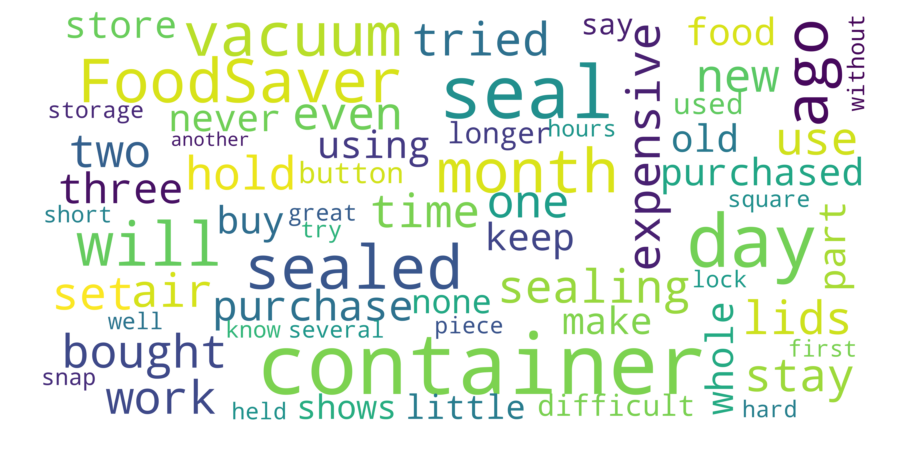

In [35]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

split_title = [x.split(" ") for x in df['reviews.text'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()